# Linking

Linking assigns the detected features and segments in each timestep to trajectories, to enable an analysis of their time evolution. We start by loading the usual libraries:

In [1]:
import tobac
import numpy as np
import seaborn as sns
sns.set_context('talk')
import matplotlib.pyplot as plt
%matplotlib inline

Since it has a time dimension, the sample data from the testing utilities is also suitable for a demonstration of this step. At first, loading in the data and performing the usual feature detection and segmentation is required:

In [2]:
%%capture

data = tobac.testing.make_sample_data_2D_3blobs_inv()
dxy, dt = tobac.utils.get_spacings(data)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=1)
mask, features = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=1)

Now the linking via trackpy can be performed. Notice that the temporal spacing is also a required input this time. Additionally, it is necessary to provide either a maximum speed *v_max* or a maximum search range *d_max*. Here we use a maximum speed of 100 m/s:

In [3]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100)

Frame 69: 2 trajectories present.


The output tells us, that in frame 69 two trajecteries where present. If we checkout this frame via imshow, we can see that this corresponds to the two present features there, which are assigned to different trajectories.

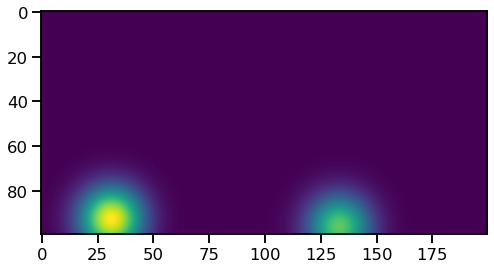

In [4]:
plt.figure(figsize = (8, 8))
plt.imshow(data[69])
plt.show()

The track dataset contains two new variables, *cell* and *time_cell*. The first assigns the features to one of the found trajectories by an integer and the second specifies how long the feature has been present already in the data.

In [5]:
track[['cell', 'time_cell']]

<xarray.Dataset>
Dimensions:    (index: 110)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 7 ... 102 103 104 105 106 107 108 109
Data variables:
    cell       (index) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 3.0 2.0 3.0 2.0 3.0
    time_cell  (index) timedelta64[ns] 00:00:00 00:01:00 ... 00:29:00 00:19:00

Since we know that this dataset contains 3 features, whe can visualize the found tracks with masks created from the *cell* variable:

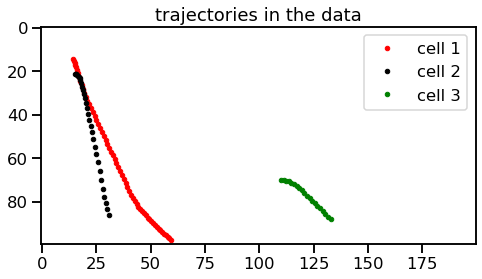

In [6]:
mask_1 = track['cell'] == 1
mask_2 = track['cell'] == 2
mask_3 = track['cell'] == 3

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))

ax.set_title('trajectories in the data')
ax.imshow(data[0], alpha = 0)
ax.plot(track.where(mask_1)['hdim_2'], track.where(mask_1)['hdim_1'], 'r.', label = 'cell 1')
ax.plot(track.where(mask_2)['hdim_2'], track.where(mask_2)['hdim_1'], 'k.', label = 'cell 2')
ax.plot(track.where(mask_3)['hdim_2'], track.where(mask_3)['hdim_1'], 'g.', label = 'cell 3')
ax.legend()
plt.show()

If you have downloaded this notebook you can see an animation of the tracks and features in the next cell:

<IPython.core.display.Javascript object>


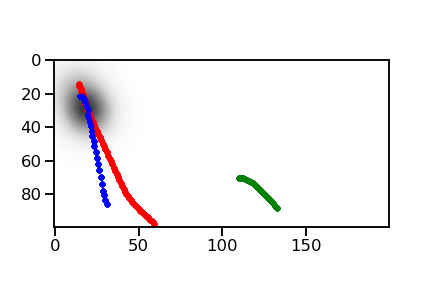

In [7]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
mask_1 = track['cell'] == 1
mask_2 = track['cell'] == 2
mask_3 = track['cell'] == 3

fig, ax = plt.subplots(ncols = 1, nrows = 1)

def animate(i):

    ax.imshow(data[i], alpha = 0.2, cmap = 'Greys')
    ax.plot(track.where(mask_1)['hdim_2'], track.where(mask_1)['hdim_1'], 'r.')
    ax.plot(track.where(mask_2)['hdim_2'], track.where(mask_2)['hdim_1'], 'b.')
    ax.plot(track.where(mask_3)['hdim_2'], track.where(mask_3)['hdim_1'], 'g.')
            
FuncAnimation(fig, animate, interval=100)

If we want to change the starting point of the cell index from 1 to 0 we can do this with the *cell_number_start* parameter:

Frame 69: 2 trajectories present.


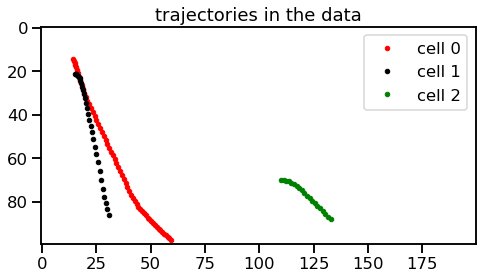

In [8]:
%matplotlib inline
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, cell_number_start=0)

mask_1 = track['cell'] == 0
mask_2 = track['cell'] == 1
mask_3 = track['cell'] == 2

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))

ax.set_title('trajectories in the data')
ax.imshow(data[0], alpha = 0)
ax.plot(track.where(mask_1)['hdim_2'], track.where(mask_1)['hdim_1'], 'r.', label = 'cell 0')
ax.plot(track.where(mask_2)['hdim_2'], track.where(mask_2)['hdim_1'], 'k.', label = 'cell 1')
ax.plot(track.where(mask_3)['hdim_2'], track.where(mask_3)['hdim_1'], 'g.', label = 'cell 2')
ax.legend()
plt.show()

## method_linking 

The linking in trackpy is performed with methods of the [trackpy](https://soft-matter.github.io/trackpy/v0.5.0/ )-library. Currently, there are two method implemented, ['random'](https://soft-matter.github.io/trackpy/dev/generated/trackpy.link.html) and ['predict'](https://soft-matter.github.io/trackpy/v0.3.0/generated/trackpy.predict.NearestVelocityPredict.html). These can be selected with the method keyword. The default is 'random'.

Frame 69: 2 trajectories present.


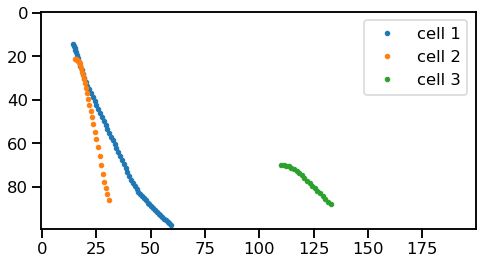

In [9]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, method_linking='predict')

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## v_max

The speed we defined before specifies a maximum of the distance a feature can travel during a timestep to

$$
d_{max} = v_{max} \Delta t.
$$

By reducing the speed we will find more cells, because a feature that is not assigned to an existing track, will be used as a starting point for a new one:

Frame 69: 2 trajectories present.


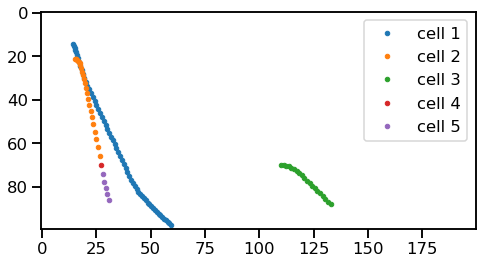

In [10]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 70)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## d_max

The same effect can be achieved by directly reducing the maximum search range with the *d_max* parameter to

$$
d_{max} = 4200 m
$$

because

$$
v_{max} \Delta t = 4200 m
$$

in our case.

Frame 69: 2 trajectories present.


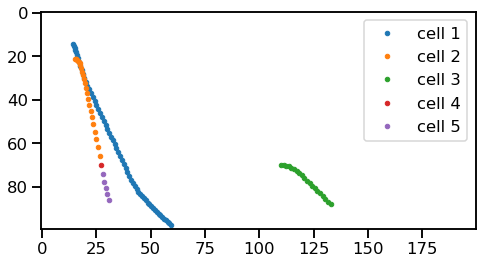

In [11]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, d_max = 4200)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

*v_max* and *d_max* should not be used together, because they both specify the same qunatity, namely the search range.

## subnetwork

If we increase *v_max* or *d_max* it can happen that more than one feature of the previous timestep is in the search range. The selection of the best matching feature from the set of possible features (which is called the subnetwork, for a more in depth explanation have a look [here](https://soft-matter.github.io/trackpy/v0.3.0/tutorial/subnets.html)) is the most time consuming part of the linking process. Therefore, the size of the subnetwork in tobac is limited to 1 by default. For this reason, increasing the search range to a high value will result in a **trackpy.SubnetOversizeException**:

Frame 69: 2 trajectories present.
tracking successful


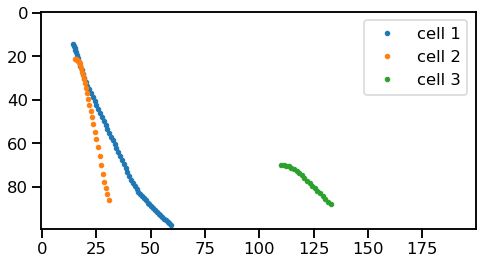

In [12]:
from trackpy import SubnetOversizeException

try:

    track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 1000)
    print('tracking successful')
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
    ax.imshow(data[0], alpha = 0)

    for i, cell_track in enumerate(track.groupby('cell')):
        ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

    ax.legend()
    plt.show()
    
except SubnetOversizeException as e:
    
    print('Tracking not possible because {}'.format(e))

## subnetwork_size

To solve this problem, the limit for the size of the subnetwork can be set to 2 with the *subnetwork_size* parameter. Now the tracking will be possible:

Frame 69: 2 trajectories present.
tracking successful


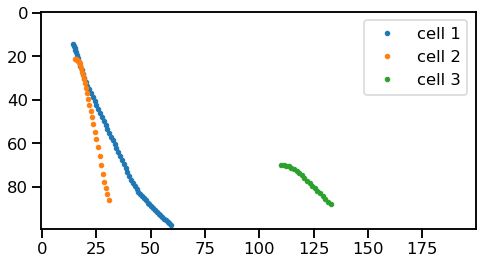

In [13]:
try:

    track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 1000, subnetwork_size=2)
    print('tracking successful')
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
    ax.imshow(data[0], alpha = 0)

    for i, cell_track in enumerate(track.groupby('cell')):
        ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

    ax.legend()
    plt.show()
    
except trackpy.SubnetOversizeException as e:
    
    print('Tracking not possible because {}'.format(e))

It is important to highlight, that if the *linking_trackpy()*-function is called with a *subnetwork_size* different from 1, this number will be the new default.

## Adaptive search

Another way of dealing with **SubnetOversizeException**s is adapative search. An extensive description can be found [here](https://soft-matter.github.io/trackpy/v0.3.0/tutorial/adaptive-search.html)

If the subnetwork is too large, the search range is reduced iterativly by multiplying it with the *adaptive_step*. The *adaptive_stop*-parameter is the lower limit of the search range. If it is reached and the subnetwork is still to large a **SubnetOversizeException** is thrown.

In [23]:
import trackpy
trackpy.linking.Linker.MAX_SUB_NET_SIZE_ADAPTIVE = 1

Frame 69: 2 trajectories present.
tracking successful


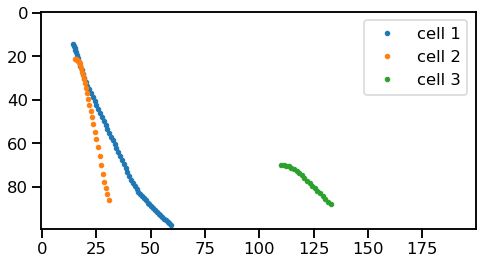

In [24]:
try:

    track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt = dt, dxy = dxy, v_max=1000, adaptive_stop=10, adaptive_step = 0.9)
    print('tracking successful')
    
    fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
    ax.imshow(data[0], alpha = 0)

    for i, cell_track in enumerate(track.groupby('cell')):
        ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

    ax.legend()
    plt.show()
    
except SubnetOversizeException as e:
    
    print('Tracking not possible because {}'.format(e))

## stups

If we want to limit our analysis to long living features of the dataset it is possible to exclude tracks which only cover few timesteps by setting a lower bound for those via the *stups* parameter:

Frame 69: 2 trajectories present.


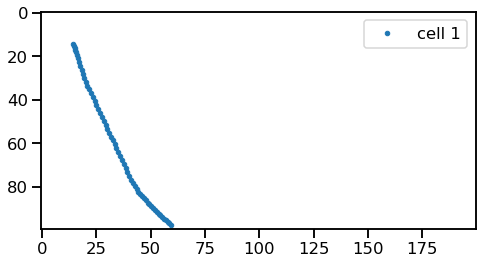

In [25]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, stubs = 50)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

## time_cell_min

Again, there is a second option for that called *time_cell_min*, where a minimum of time in minutes for a cell to appear as tracked can be definded:

Frame 69: 2 trajectories present.


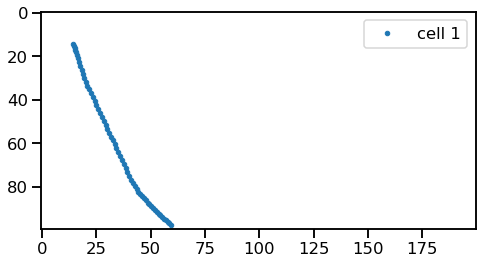

In [26]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 100, time_cell_min = 3000)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

### Not fully understood or explained yet:

## Memory  
  
  memory : int, optional
        Number of output timesteps features allowed to vanish for to
        be still considered tracked. Default is 0.
        .. warning :: This parameter should be used with caution, as it
                     can lead to erroneous trajectory linking,
                     espacially for data with low time resolution. [5]_

Frame 69: 2 trajectories present.


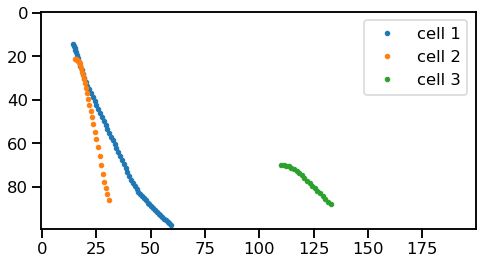

In [168]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, v_max = 10000, memory = 1000, subnetwork_size = 4, adaptive_stop=1)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

### DOES NOT WORK IN V2

## d_min

Variations in the shape of the regions used to determine the
        positions of the features can lead to quasi-instantaneous shifts
        of the position of the feature by one or two grid cells even for
        a very high temporal resolution of the input data, potentially
        jeopardising the tracking procedure. To prevent this, tobac uses
        an additional minimum radius of the search range.

Frame 69: 2 trajectories present.


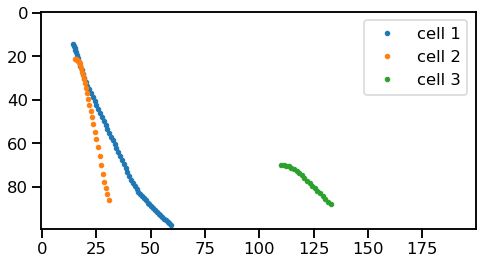

In [159]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt=dt, dxy=dxy, d_min = 6000, v_max = 100)

fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (8, 4))
ax.imshow(data[0], alpha = 0)

for i, cell_track in enumerate(track.groupby('cell')):
    ax.plot(cell_track[1]['hdim_2'], cell_track[1]['hdim_1'], marker = '.', linestyle = '', label = 'cell {}'.format(i+1))

ax.legend()
plt.show()

### parts in v2 that are commented:

##  extrapolate

not used in V2

## order

not used in V2